# Быстрая оценка эффекта рекламы/события на ключевые показатели: Python + Causal Impact

Приветствую, меня зовут Владислав Поляков, я аналитик данных в Сбербанке. Я уже не раз сталкивался с задачами, которые содержат в себе ключевые слова «оценка эффекта», и, как правило, такие задачи нужно делать быстро. Сегодня я хочу поделиться, пожалуй, самым простым и быстрым способом оценки эффекта от рекламы/события на ключевые показатели. Способ заключается в использовании библиотеки pycausalimpact для Python. Документация к библиотеке: https://pypi.org/project/pycausalimpact/. 

Вводные:
•	Данные: Данные ЦБ РФ по ключевой ставке и объему выданных кредитов с 2013 года.
•	Что будем оценивать?: Как повышение ключевой ставки повлияло на объем выданных кредитов.
•	Как будем оценивать?: С помощью библиотеки pycausalimpact для Python

## Установка библиотеки

In [1]:
!pip install pycausalimpact

  Obtaining dependency information for pycausalimpact from https://files.pythonhosted.org/packages/e2/cd/2f9b327f58d5918c5c193434b733a6eafaf8a876ce30182f16216cba7001/pycausalimpact-0.1.1-py2.py3-none-any.whl.metadata


# Импорт библиотек и загрузка данных

In [2]:
import pandas as pd
from causalimpact import CausalImpact
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(font_scale=1)

df = pd.read_excel('amt_key.xlsx')
df.columns = ['date', 'cred_amt', 'key_value_perc']
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date')
df.head(3)

,cred_amt,key_value_perc
date,,
2013-09-30,720230,0.055
2013-10-31,776353,0.055
2013-11-30,736822,0.055


# Построение графиков и предобработка данных

Я уже собрал данные ЦБ РФ по ключевой ставке и объему выданных кредитов с сентября 2013 года по май 2024 года. Данные будут лежать в репозитории GitHub. Вот как они выглядят:

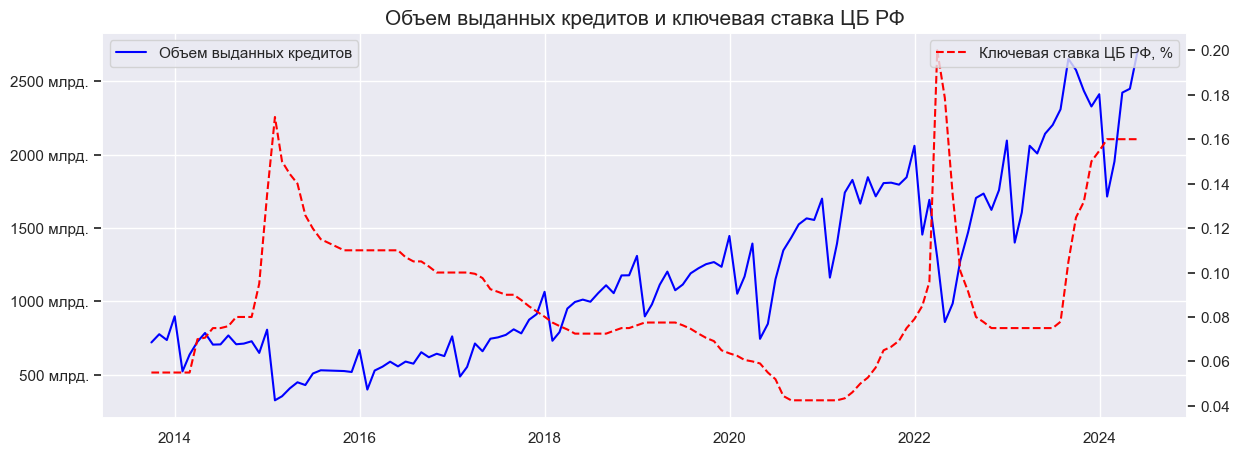

In [3]:
import warnings as w
w.filterwarnings('ignore')

fig, ax1 = plt.subplots(figsize=(14, 5))
ax2 = ax1.twinx()

ax1.plot(df['cred_amt'], color='blue', label='Объем выданных кредитов, млн. руб.');
ax2.plot(df['key_value_perc'], color='red', label='Ключевая ставка ЦБ РФ, %', ls='--');
ax1.legend(['Объем выданных кредитов']);
ax1.set_yticklabels(['{:.0f} млрд.'.format(x*1000000/1000000000) for x in ax1.get_yticks()])
ax2.legend(['Ключевая ставка ЦБ РФ, %'], loc='upper right');
ax2.grid(False)
plt.title('Объем выданных кредитов и ключевая ставка ЦБ РФ', fontsize=15);

Теперь определим период для оценки влияния ключевой ставки на объем выданных кредитов. Для примера возьмем ситуацию в марте 2022 года, когда ЦБ РФ резко поднял ключевую ставку с 9,58% до 20,00% и оценим, насколько уменьшился объем выданных кредитов относительно ситуации, если бы ЦБ РФ не поднимал ставку.

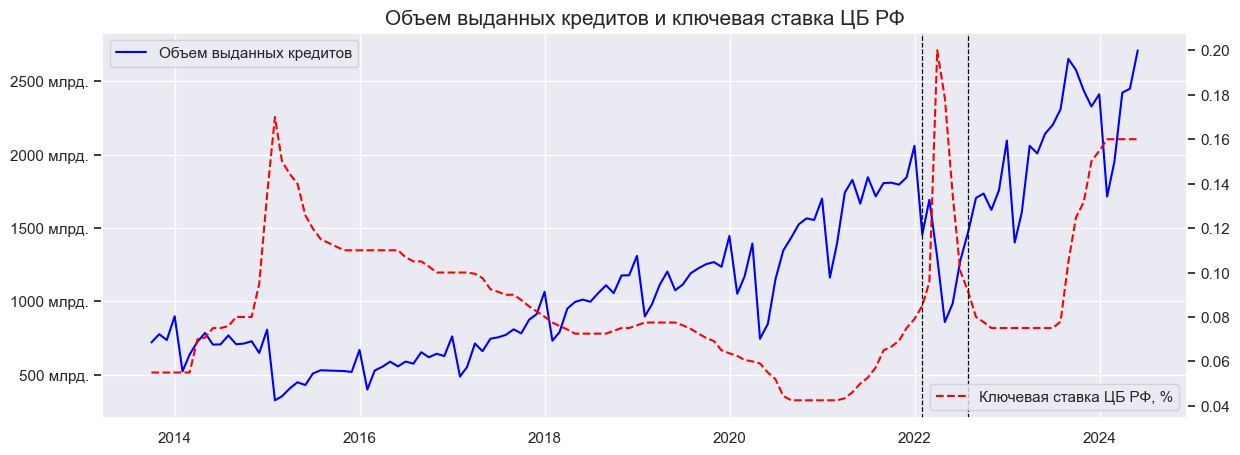

In [4]:
import warnings as w
w.filterwarnings('ignore')

fig, ax1 = plt.subplots(figsize=(14, 5))
ax2 = ax1.twinx()

ax1.plot(df['cred_amt'], color='blue', label='Объем выданных кредитов, млн. руб.');
ax2.plot(df['key_value_perc'], color='red', label='Ключевая ставка ЦБ РФ, %', ls='--');
ax1.legend(['Объем выданных кредитов']);
ax1.set_yticklabels(['{:.0f} млрд.'.format(x*1000000/1000000000) for x in ax1.get_yticks()])
ax2.legend(['Ключевая ставка ЦБ РФ, %'], loc='lower right');
ax2.grid(False)
plt.title('Объем выданных кредитов и ключевая ставка ЦБ РФ', fontsize=15);
plt.axvline(pd.to_datetime('2022-01-31'), color='black', ls='--', lw=0.9);
plt.axvline(pd.to_datetime('2022-07-31'), color='black', ls='--', lw=0.9);

Для предсказания Causal Impact использует Линейную регрессию и для нее, как и для любой модели, действует правило – чем больше данных, тем лучше прогноз. Поэтому создадим дополнительные предикторы (признаки) для нашей модели на основе тех данных, которые у нас есть. Для этого я создал функцию create_features.

In [5]:
def create_features(df_in, lags=3, target='cred_amt'):
    tmp = df_in.copy()
    tmp['day'] = tmp.index.day
    tmp['year'] = tmp.index.year
    tmp['month'] = tmp.index.month
    tmp['month_to_new_year'] = 12 - tmp.index.month
    
    tmp['rolling_mean_{}'.format(lags)] = tmp[target].rolling(lags, closed='left').mean()
    for lag in range(1, lags+1):
        tmp['lag_{}'.format(lag)] = tmp[target].shift(lag)
    
    return tmp

После создания новых признаков наши данные выглядят следующим образом:

In [6]:
train_data = create_features(df).dropna()
train_data

,cred_amt,key_value_perc,day,year,month,month_to_new_year,rolling_mean_3,lag_1,lag_2,lag_3
date,,,,,,,,,,
2013-12-31,898756,0.055000,31,2013,12,0,7.444683e+05,736822.0,776353.0,720230.0
2014-01-31,523223,0.055000,31,2014,1,11,8.039770e+05,898756.0,736822.0,776353.0
2014-02-28,637611,0.055000,28,2014,2,10,7.196003e+05,523223.0,898756.0,736822.0
2014-03-31,725301,0.070000,31,2014,3,9,6.865300e+05,637611.0,523223.0,898756.0
2014-04-30,784935,0.070682,30,2014,4,8,6.287117e+05,725301.0,637611.0,523223.0
...,...,...,...,...,...,...,...,...,...,...
2024-01-31,1714628,0.160000,31,2024,1,11,2.391820e+06,2411821.0,2328325.0,2435314.0
2024-02-29,1953600,0.160000,29,2024,2,10,2.151591e+06,1714628.0,2411821.0,2328325.0
2024-03-31,2422719,0.160000,31,2024,3,9,2.026683e+06,1953600.0,1714628.0,2411821.0


Также для точности добавим такой показатель как количество населения России. Ведь население росло, а от этого и рос объем выданных кредитов. Данные о количестве населения я взял из Росстата (https://rosstat.gov.ru/storage/mediabank/Popul_1897+.xlsx).

In [7]:
pop = pd.read_excel('rf_population.xlsx')

train_index = train_data.index
train_data = train_data.merge(pop, left_on='year', right_on='date')
train_data.index = train_index

train_data

,cred_amt,key_value_perc,day,year,month,month_to_new_year,rolling_mean_3,lag_1,lag_2,lag_3,date,population,city_population,village_population,city_pop_perc,village_pop_perc
date,,,,,,,,,,,,,,,,
2013-12-31,898756,0.055000,31,2013,12,0,7.444683e+05,736822.0,776353.0,720230.0,2013,143.6,106.4,37.2,74,26
2014-01-31,523223,0.055000,31,2014,1,11,8.039770e+05,898756.0,736822.0,776353.0,2014,144.0,106.9,37.1,74,26
2014-02-28,637611,0.055000,28,2014,2,10,7.196003e+05,523223.0,898756.0,736822.0,2014,144.0,106.9,37.1,74,26
2014-03-31,725301,0.070000,31,2014,3,9,6.865300e+05,637611.0,523223.0,898756.0,2014,144.0,106.9,37.1,74,26
2014-04-30,784935,0.070682,30,2014,4,8,6.287117e+05,725301.0,637611.0,523223.0,2014,144.0,106.9,37.1,74,26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-31,1714628,0.160000,31,2024,1,11,2.391820e+06,2411821.0,2328325.0,2435314.0,2024,146.1,109.5,36.6,75,25
2024-02-29,1953600,0.160000,29,2024,2,10,2.151591e+06,1714628.0,2411821.0,2328325.0,2024,146.1,109.5,36.6,75,25
2024-03-31,2422719,0.160000,31,2024,3,9,2.026683e+06,1953600.0,1714628.0,2411821.0,2024,146.1,109.5,36.6,75,25


**Важно отметить:** При подаче данных в пакет Causal Impact, мы должны соблюдать следующее правило. В индексе наших данных должна быть дата, первым столбцом должен идти целевой показатель, а последующими столбцами должны быть признаки.

# Использование Causal Impact

Данные подготовлены, осталось всего ничего! Используем Causal Impact для оценки эффекта от повышения ключевой ставки.
Для начала импортируем библиотеку и зададим временные рамки

Здесь training_start и training_end (включительно) – обозначают период до возникновения события. treatment_start и treatment_end – обозначают период, когда событие продолжалось.

Нам остается лишь подать данные в функцию CausalImpact:

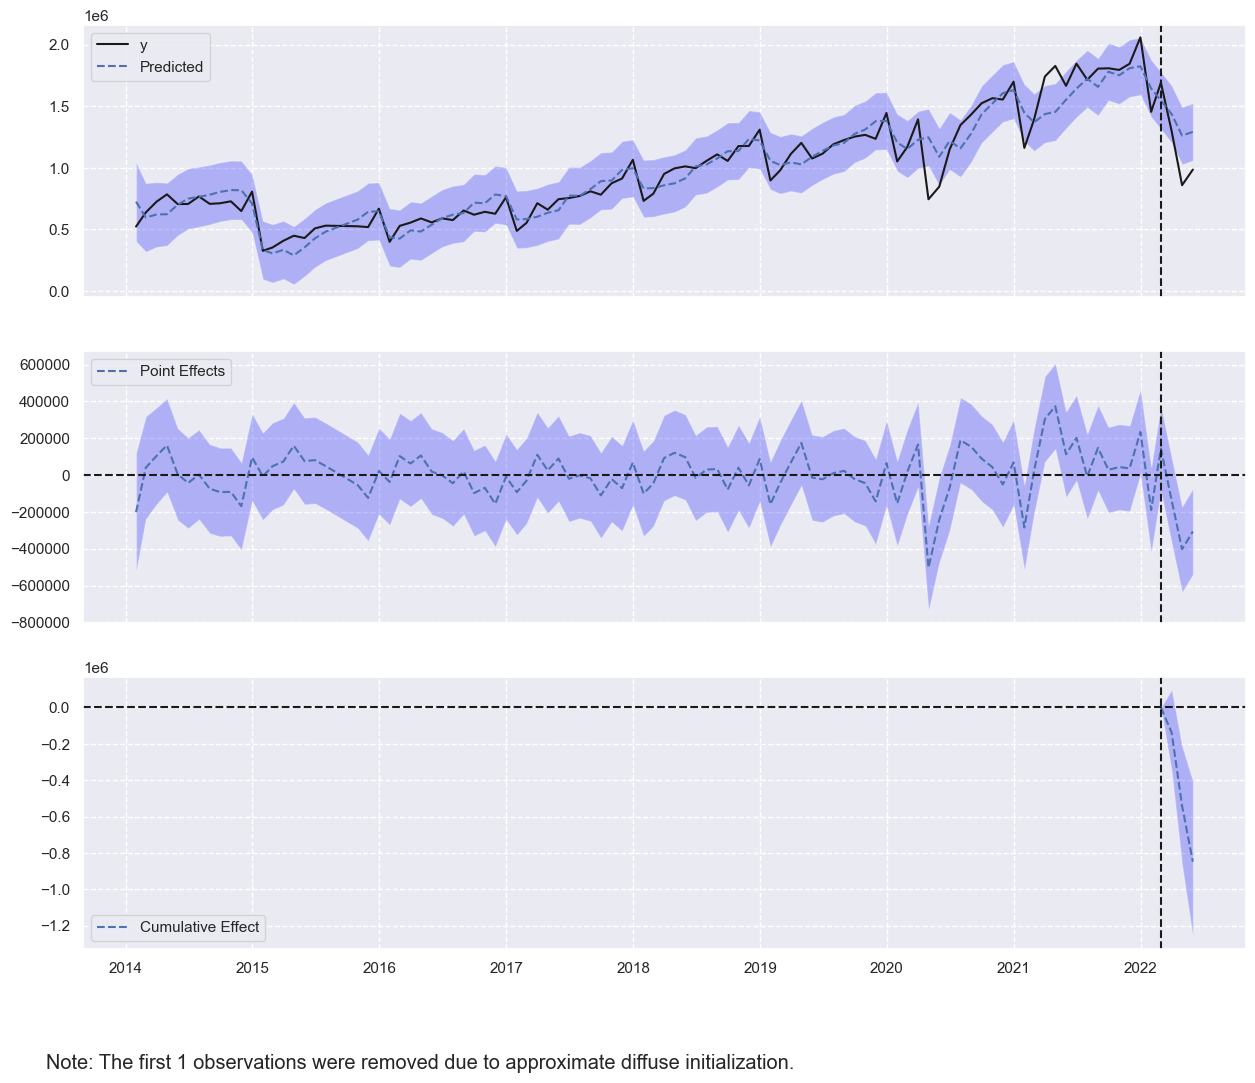

In [10]:
from causalimpact import CausalImpact
import warnings as w
w.filterwarnings('ignore')

training_start = '2013-12-31'
training_end = '2022-02-28'
treatment_start = '2022-03-31'
treatment_end = '2022-05-31'

impact = CausalImpact(
    train_data,
    pre_period = [training_start, training_end],
    post_period = [treatment_start, treatment_end]
)

# После того, как функция приняла наши 
# данные и обучила линейную регрессию 
# на периоде до возникновения события, 
# мы можем построить графики с помощью следующей команды:

impact.plot();

**Первый график** – самый важный, на нем пунктиром изображен прогноз линейной регрессии, а сплошной линией фактические данные.

Но, чтобы не пытаться оценить эффект по картинке, мы можем использовать функцию, которая выдаст нам подробное описание эффекта:

In [11]:
print(impact.summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    1047795.67         3143387.0
Prediction (s.d.)         1330227.49 (72802.25)3990682.47 (218406.76)
95% CI                    [1182246.93, 1467626.53][3546740.79, 4402879.58]

Absolute effect (s.d.)    -282431.82 (72802.25)-847295.47 (218406.76)
95% CI                    [-419830.86, -134451.26][-1259492.58, -403353.79]

Relative effect (s.d.)    -21.23% (5.47%)    -21.23% (5.47%)
95% CI                    [-31.56%, -10.11%] [-31.56%, -10.11%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 100.0%

For more details run the command: print(impact.summary('report'))


Может случится и такое, что мы увидим высокое значения p-value и, например, вероятность около 60%. Это будет означать, что вероятность того, что изменение ключевого показателя это следствие какого-то события, довольно мала, и мы не можем утверждать, что какой-то эффект вообще был.

Получить предсказания, которые сделал пакет Causal Impact, можно с помощью следующего метода:

In [12]:
impact.inferences

,post_cum_y,preds,post_preds,post_preds_lower,post_preds_upper,preds_lower,preds_upper,post_cum_pred,post_cum_pred_lower,post_cum_pred_upper,point_effects,point_effects_lower,point_effects_upper,post_cum_effects,post_cum_effects_lower,post_cum_effects_upper
date,,,,,,,,,,,,,,,,
2013-12-31,NaN,8.601104e+05,NaN,NaN,NaN,-8.299301e+08,8.316503e+08,NaN,NaN,NaN,38645.578229,-8.307516e+08,8.308289e+08,NaN,NaN,NaN
2014-01-31,NaN,7.249764e+05,NaN,NaN,NaN,4.030163e+05,1.046937e+06,NaN,NaN,NaN,-201753.442596,-5.237136e+05,1.202067e+05,NaN,NaN,NaN
2014-02-28,NaN,5.975784e+05,NaN,NaN,NaN,3.186637e+05,8.764931e+05,NaN,NaN,NaN,40032.606520,-2.388821e+05,3.189473e+05,NaN,NaN,NaN
2014-03-31,NaN,6.211360e+05,NaN,NaN,NaN,3.580888e+05,8.841831e+05,NaN,NaN,NaN,104165.016973,-1.588821e+05,3.672122e+05,NaN,NaN,NaN
2014-04-30,NaN,6.233978e+05,NaN,NaN,NaN,3.686225e+05,8.781731e+05,NaN,NaN,NaN,161537.183928,-9.323809e+04,4.163125e+05,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-31,NaN,1.645017e+06,NaN,NaN,NaN,1.412424e+06,1.877609e+06,NaN,NaN,NaN,-189793.606970,-4.223863e+05,4.279911e+04,NaN,NaN,NaN
2022-02-28,0.0,1.547886e+06,NaN,NaN,NaN,1.315293e+06,1.780478e+06,0.000000e+00,0.000000e+00,0.000000e+00,144182.029908,-8.841049e+04,3.767746e+05,0.000000,0.000000e+00,0.000000
2022-03-31,1298097.0,1.435913e+06,1.435913e+06,1.203321e+06,1.668505e+06,1.203321e+06,1.668505e+06,1.435913e+06,1.199736e+06,1.648986e+06,-137815.986570,-3.704083e+05,9.477635e+04,-137815.986570,-3.508893e+05,98360.966443


# Вывод

Итак, мы применили библиотеку pycausalimpact на реальных данных и оценили, как повлияло резкое повышение ключевой ставки в марте 2022 года с 9,58% до 20,00% на объем выданных кредитов физическим лицам:

- Абсолютный эффект от резкого повышения ключевой ставки составил в среднем -282 млрд. руб./мес. (плюс минус 75 млрд. руб.).

- Объем выданных кредитов оказался ниже ожидаемого в среднем на 21% (плюс минус 6%) в месяц

Спасибо за внимание! Если эта статья была для вас полезной, поделитесь ею с коллегами и друзьями. Если у вас есть вопросы или предложения, не стесняйтесь оставлять комментарии. Удачи в ваших аналитических проектах и до новых встреч!  